# Clustering Maps

Within each of the neighborhoods, there are several versions of each map. In this analysis, we'll  cluster version of each of the maps, based on the variations of the maps and the size of the region formed by the four ground control point intersections. 

For instance, here are two versions of the East Village map.

<table>
<tr>
<td><img src="http://ds.civicknowledge.org/downtownsandiego.org/homeless-count/east_villiage/201601-000.png" width="400"></td>
<td><img src="http://ds.civicknowledge.org/downtownsandiego.org/homeless-count/east_villiage/201401-002.png" width="400"></td>
</tr>
</table>

Part of the process for digitizing these maps is to annotate four well-known intersections on each map; these intersection positions are known as ground control points. These annotations are used to transform pixel position to geographic coordinates, but they can also be used to determine the scale for a map, but looking at the four positions as a rectangle. Here is the intersection polygon for the East Village Maps.

!["East Village Intersection Region"](ev-intersection-region.png "East Village Intersection Region")

We can use the (x,y) coordinates for these rectangles to do a k-means clustering on the maps, and later use the map grouping and scale information as input to extracting features that can help identify similar maps in the future. 



In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 
from kneed import KneeLocator 
from shapely import wkt
import dtcv 
from dtcv.images import get_image, upper_left
from dtcv.plotting import * 
from sklearn.cluster import KMeans
import statsmodels.api as sm
import cv2

base_cmap = plt.get_cmap('gist_rainbow')

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


# Load in the CV Datasets

First, load in the Downtown Homelessness Computer Vision datasets. 


In [2]:
pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg

# San Diego Downtown Homless Computer Vision Package
`sandiegodata.org-downtown_cv-4` Last Update: 2019-09-13T01:02:13

_Files and code for analyzing San Diego downtown homelessness  data with computer vision_


This dataset collects records related to a conversion of 5 years of paper maps
that record positions of homeless sleepers in downtown San Diego. The San Diego
Regional Data Library is [converting these paper maps to a digital
form](http://downtown-homelessness.sandiegodata.org/) with a manual process that
uses an image annotation tool, and theses annotations can be used to train
computer vision algorithms to georeference maps and recognize handwritten marks.

These datasets link to map urls and annotations, for three kinds of annotations:

* Ground Control Points, which identify the map image locations for known intersections, linking image coordinates ( in pixels ) to geographic coordinates.
* Image locations of handwritten marks and the number written in the mark.
* File annotations, for other handwritten notes such as the temperature and presence of rain. 

For more discussion about the GCP and handwritten marks, and the tasks in volved
in developing computer vision algorithms for these data, [see our recent blog
post on the subject.
](https://www.sandiegodata.org/2019/09/computer-vision-for-greater-good/)

For some examples of using OpenCV to extract and match templates, to georeference maps, see the [Templates and Clustering Jupyter Notebook](https://nbviewer.jupyter.org/github/sandiegodata-projects/homelessness/blob/master/datasets/sandiegodata.org-downtown_cv/notebooks/Template%20Matching%20Clusters.ipynb)


## Developer notes

After anotation JSON files are copied into S#, the list of S# urls must be
updated. To refresh the list of urls run

    $  bin/update_s3.sh <s3-profile>


 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [gcp](data/gcp.csv)**. Ground control points
* ** [intersection_regions](data/intersection_regions.csv)**. Polygon transformations for each the intersections of each map
* ** [intersections](data/intersections.csv)**. List of intersections.
* ** [file_annotations](data/file_annotations.csv)**. File annotations on count files
* ** [counts](data/counts.csv)**. Annotation position, types and counts of handwritten marks

The ``intersection_regions`` dataset has URLS for each of the map images, as well as Shapely ( WKT format ) polygons composed of the intersection points. The ``gcp`` dataset has the individual, labeld intersections, but for our purposes, the polygons are easier to use. 

In [3]:
r = pkg.resource('intersection_regions')
df = r.dataframe()
display(r)
df.head().T

Header,Type,Description
image_url,string,Url to a map image
neighborhood,string,Name of the neighborhood for the maps
year,integer,Year portion of the data collection date.
month,integer,Month portion of the data collection date.
intersections_id,string,A string composed of the names of the four intersections.
intersection_group,string,"A name, based on the neighbrhood, that identifies distinct intersection_id strings."
map_name,string,A name based on the neighborhood and map changes in 2016 and 2017
source_inv,string,"The intersection polygon, fromed from the intersection points, in WKT format, in the pixel coordinate space. This version is inverted, with the Y coordinate being subtracted from 2000, so the orientation of the Y axis is the same as the EPSG:2230 geographic coordinate space."
source,string,"Like source_inv, but the Y axis is not inverted, so the coordinates are the same as the image."
source_area,number,"Area of source shape, in square pixels"


,0,1,2,3,4
image_url,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....
neighborhood,columbia,columbia,columbia,columbia,columbia
year,2015,2016,2016,2016,2016
month,9,1,2,3,4
intersections_id,"Ketner_A,Ketner_Broadway,State_A,State_Broadway","Ketner_A,Ketner_Broadway,State_A,State_Broadway","Ketner_A,Ketner_Broadway,State_A,State_Broadway","Ketner_A,Ketner_Broadway,State_A,State_Broadway","Ketner_A,Ketner_Broadway,State_A,State_Broadway"
intersection_group,a,a,a,a,a
map_name,columbia_14,columbia_16,columbia_16,columbia_16,columbia_16
source_inv,"POLYGON ((262 1743, 262.5 1123, 585.5 1118.5, ...","POLYGON ((832.5 1161, 827.5 753.5, 1541.5 750....","POLYGON ((605 1426.5, 602 1086, 1188 1086, 118...","POLYGON ((844.5 1227.5, 848.5 777.5, 1626.5 77...","POLYGON ((627 1423, 626 1097.5, 1186.5 1095.5,..."
source,"POLYGON ((262 257, 262.5 877, 585.5 881.5, 590...","POLYGON ((832.5 839, 827.5 1246.5, 1541.5 1249...","POLYGON ((605 573.5, 602 914, 1188 914, 1185 5...","POLYGON ((844.5 772.5, 848.5 1222.5, 1626.5 12...","POLYGON ((627 577, 626 902.5, 1186.5 904.5, 11..."
source_area,202299,291446,197346,352782,182724


For the East Village neighborhood, there are two kinds of maps that are different enough ( East Village South )  that the neightborhood has two sets of intersections. The ``intersections_id`` variable identifies this case. 

## Intersection Shape Clusters 

First, let's get a view of what the space of intersection shape looks like. Here is a plot of all of the map intersection shapes, by width and height, and colored by the intersection_id, showing some clear patterns. In particular, it looks like all of the regions for a particular neighborhood all line on a line, which means that they are just scaled versions of each other, with a constant aspect ratio. And, there appear to be clusters of points. 

That gives us two interesting ways to categorize the maps: K-Means clustering, to find the clusters, and fitting them to a line.

Fitting them to a line is probably really easy, because the lines all intersect 0, and the slope will just be the ratio of Y to X. 



In [4]:

dims = pd.DataFrame({
    'map_no': df.map_name.astype('category').cat.codes,
    'map_name': df.map_name,
    'x': df.source_shape_x,
    'y': df.source_shape_y,
    'image_url': df.image_url
}).set_index('image_url')


The line fits look interesting,  but there are high, and very variable, y intercepts. I'd expect these all to be zero, because as the size of the region gets smaller, both the width and height should approach zero. Let's look at this again with a fit that does not use a constant, forcing the y intercept to be zero. 

columbia_14 [1.87878788]
columbia_16 [-18.86854332   0.61218912]
columbia_17 [131.23412362   0.78418713]
core_columbia_14 [-9.57178204  0.3662447 ]
core_columbia_16 [-9.01832516  0.18763366]
core_columbia_17 [-3.02568218  0.25428036]
cortez_14 [0.68972567 0.41319563]
cortez_16 [8.66225166 0.32847682]
cortez_17 [21.08961615  0.34320997]
east_village_14 [5.02188655 1.03335638]
east_village_16 [85.76199979  0.50504149]
east_village_17 [225.04447811   0.33290603]
gaslamp_14 [49.91247387  2.97306099]
gaslamp_16 [72.44680851  2.21735977]
gaslamp_17 [277.23437062   1.47981497]
marina_14 [-10.59046315   0.58911836]
marina_16 [13.92884615  0.43865385]
marina_17 [55.99875699  0.60658794]


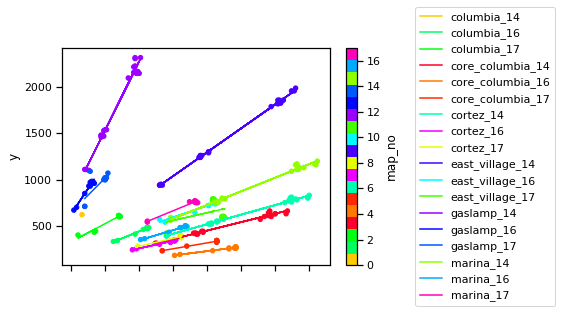

In [5]:

groups = dims.groupby(['map_name', 'map_no'])

cmap = resample_reorder_cmap(base_cmap,len(groups))

ax = dims.plot.scatter(x='x',y='y',c='map_no', colormap=cmap)

for (name, num), g in groups:
    Y = g.y.to_numpy()
    X = g.x.to_numpy()
    Xc = sm.add_constant(X)
    model = sm.OLS(Y,Xc)
    results = model.fit()
    print(name,  results.params)
   
    
    ax.plot(X, results.predict(Xc), label=name, color=cmap(num))
    
plt.legend(loc='center left', bbox_to_anchor=(1.3, 0.5));

Without the constant, it is more clear that the regression lines run through the middle of groups within each map that are linear within the group. For instance, the red line for Cortez, which runs through the sea-foam green points for Cortez, seems to run through two separate groups, one above the regression line, and one below. Other neighborhoods, like columbia, 

In [6]:
groups.size()

map_name          map_no
columbia_14       0          1
columbia_16       1         15
columbia_17       2         15
core_columbia_14  3         23
core_columbia_16  4         15
core_columbia_17  5         15
cortez_14         6         24
cortez_16         7         15
cortez_17         8         15
east_village_14   9         24
east_village_16   10        15
east_village_17   11        26
gaslamp_14        12        23
gaslamp_16        13        15
gaslamp_17        14        15
marina_14         15        24
marina_16         16        15
marina_17         17        15
dtype: int64

columbia_14 1.878787878787879
columbia_16 0.5879914430441483
columbia_17 1.0129378484066898
core_columbia_14 0.3598779944063882
core_columbia_16 0.18118885500072282
core_columbia_17 0.25189403484016193
cortez_14 0.4136180074799075
cortez_16 0.3374025044722717
cortez_17 0.36376267800430295
east_village_14 1.0365958668197477
east_village_16 0.5735955346529538
east_village_17 0.5043044684267859
gaslamp_14 3.052536485289319
gaslamp_16 2.404971024990945
gaslamp_17 2.0565585042572487
marina_14 0.5828126247626086
marina_16 0.45194709546751755
marina_17 0.6563124760729933


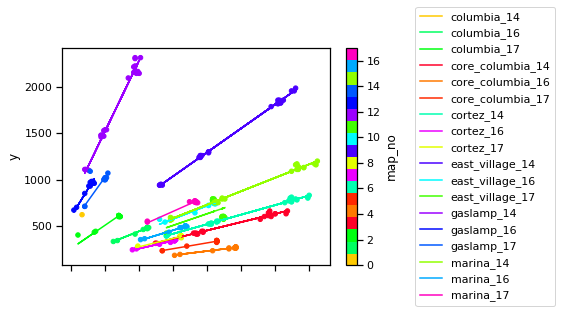

In [7]:
groups = dims.groupby(['map_name', 'map_no'])

ax = dims.plot.scatter(x='x',y='y',c='map_no', colormap=cmap)

for (name, num), g in groups:
    
    Y = g.y.to_numpy()
    X = g.x.to_numpy()

    model = sm.OLS(Y,X)
    results = model.fit()
    print(name,  results.params[0])
    
    ax.plot(X, results.predict(X), label=name, color=cmap(num))
    
plt.legend(loc='center left', bbox_to_anchor=(1.3, 0.5));

## K-Means Clustering

The other idea for clustering is k-means. The k-means procedure unfortunately requires knowing how many clusters you want, and we don't know. But, we do nknow it is a small number. So, we can run the process multiple times and look for the number of clusters where the matching score is sufficiently good.  The scores will ( should form a plot ) with a knee, which you can find easily with the [kneed package](https://pypi.org/project/kneed/)


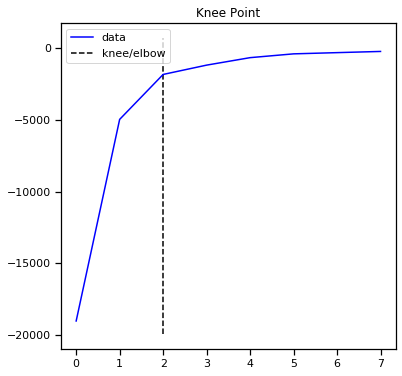

In [8]:
t = dims[dims.map_name == 'gaslamp_16']
X = t[['x','y']].values

scores = []

for i in range(2,10):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    pred = kmeans.predict(X)
    scores.append(kmeans.score(X))

knee = KneeLocator(x=range(len(scores)), y=scores)

knee.plot_knee();

Here is the whole procedure to first run multiple k-means to find the optimal clusters, then run it one more time to find the clusters. 

In [9]:
##
## Use KMeans to find clusters of region point shapes, to identify different kinds of maps. 
##
dims['cluster'] = None

# Force some of the maps to a specific number of clusters. 
force_clusters = {
    'east_village_c': 2 # Not clear why it finds 4, not 2
}




for name, g in dims.groupby('map_name'):
    X = g[['x','y']].values
    
    # If there isn't a lot of variation in the shapes, then skip
    # the clustering. 
    m = X.mean(axis=0) # Centroid
    
    s = [np.linalg.norm(x-m) for x in X]
    
    if pd.Series(s).std() > 100:
    
        #
        # Run the KMeans multiple times and look for the knee in the
        # score vs #clusters plot

        if not name in force_clusters:
            scores = []
            n_clusters = []
            for i in range(2,10):
                kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
                pred = kmeans.predict(X)
                scores.append(kmeans.score(X))
                n_clusters.append(i)

            knee = KneeLocator(x=range(len(scores)), y=scores).knee
            clusters = n_clusters[knee]
        else:
            clusters = force_clusters[name]

        # Now re-run with that number of clusters. 

        kmeans = KMeans(n_clusters=clusters, random_state=0).fit(X)
        pred = kmeans.predict(X)
    else:
        print('Skipping ', name)
        pred = 0
    
    dims.loc[dims.map_name==name,'cluster'] = pred
   

Skipping  columbia_14
Skipping  columbia_16
Skipping  columbia_17


/Users/eric/anaconda3/envs/metatab-dev/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


Skipping  core_columbia_17
Skipping  cortez_16
Skipping  cortez_17


/Users/eric/anaconda3/envs/metatab-dev/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


Skipping  east_village_17
Skipping  gaslamp_16
Skipping  gaslamp_17
Skipping  marina_16


/Users/eric/anaconda3/envs/metatab-dev/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


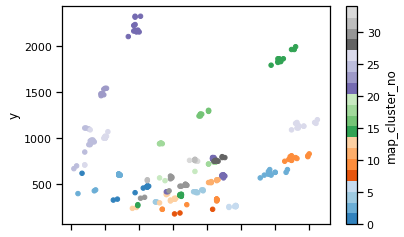

In [10]:
dims['map_cluster'] = dims.apply(lambda r: f"{r.map_name}-{r.cluster}", axis=1)
dims['map_cluster_no'] = dims.map_cluster.astype('category').cat.codes
dims.plot.scatter(x='x',y='y',c='map_cluster_no', colormap='tab20c');

That seemed to work, so let's look at the regression again, this time on the clusters, and ignoring the y-intercept. 


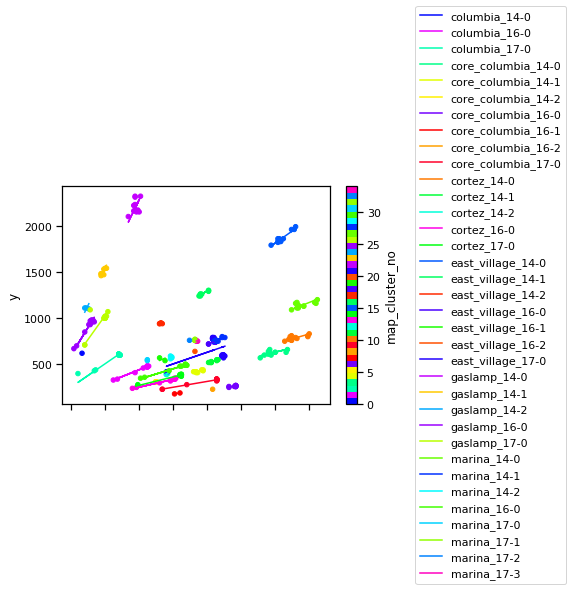

In [11]:
groups = dims.groupby(['map_cluster', 'map_cluster_no'])

cmap = resample_reorder_cmap(base_cmap,len(groups)) # rand_cmap(len(groups), type='bright')

ax = dims.plot.scatter(x='x',y='y',c='map_cluster_no', colormap=cmap)

import statsmodels.api as sm
for (name, num), g in groups:
    Y = g.y.to_numpy()
    X = g.x.to_numpy()
    
    model = sm.OLS(Y,X)
    results = model.fit()
   
    ax.plot(X, results.predict(X), label=name, color=cmap(num))
    
plt.legend(loc='center left', bbox_to_anchor=(1.3, 0.5));

These clusters look very good, mostly organized around the regression lines, so we can merge the cluster values back into the main dataset and use the clusters for further analysis. 

In [12]:
df = df.merge(dims.reset_index()[['image_url','map_cluster']])

In [13]:
df.head().T

,0,1,2,3,4
image_url,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....
neighborhood,columbia,columbia,columbia,columbia,columbia
year,2015,2016,2016,2016,2016
month,9,1,2,3,4
intersections_id,"Ketner_A,Ketner_Broadway,State_A,State_Broadway","Ketner_A,Ketner_Broadway,State_A,State_Broadway","Ketner_A,Ketner_Broadway,State_A,State_Broadway","Ketner_A,Ketner_Broadway,State_A,State_Broadway","Ketner_A,Ketner_Broadway,State_A,State_Broadway"
intersection_group,a,a,a,a,a
map_name,columbia_14,columbia_16,columbia_16,columbia_16,columbia_16
source_inv,"POLYGON ((262 1743, 262.5 1123, 585.5 1118.5, ...","POLYGON ((832.5 1161, 827.5 753.5, 1541.5 750....","POLYGON ((605 1426.5, 602 1086, 1188 1086, 118...","POLYGON ((844.5 1227.5, 848.5 777.5, 1626.5 77...","POLYGON ((627 1423, 626 1097.5, 1186.5 1095.5,..."
source,"POLYGON ((262 257, 262.5 877, 585.5 881.5, 590...","POLYGON ((832.5 839, 827.5 1246.5, 1541.5 1249...","POLYGON ((605 573.5, 602 914, 1188 914, 1185 5...","POLYGON ((844.5 772.5, 848.5 1222.5, 1626.5 12...","POLYGON ((627 577, 626 902.5, 1186.5 904.5, 11..."
source_area,202299,291446,197346,352782,182724


Here are the first images, and the intersections polygon, from one image from each of the clusters. 

## Template Matching

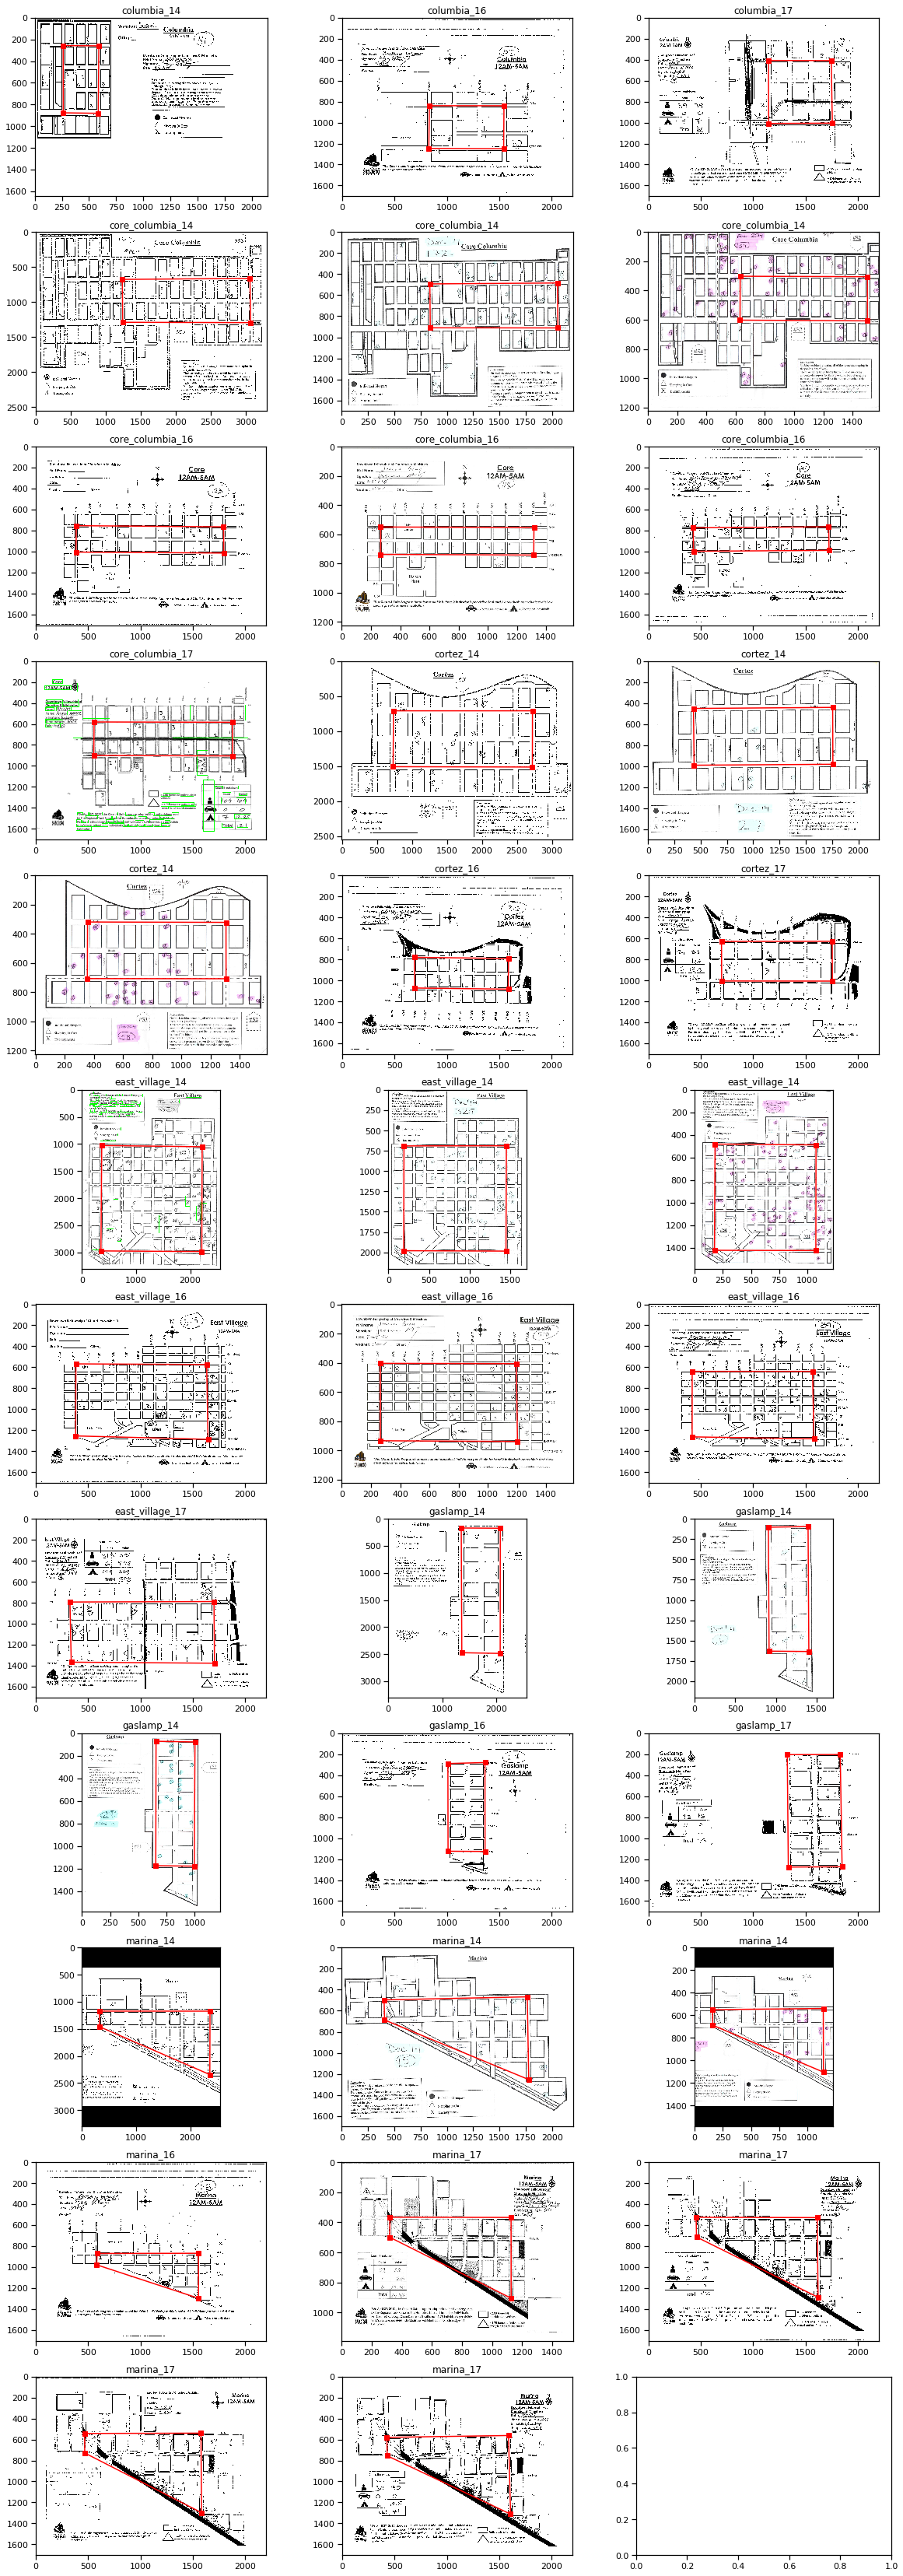

In [14]:
plot_image_and_poly(df.groupby('map_cluster').first(), max_x=3, figsize=(20,60),
                   titlef=lambda r: r.map_name)

Crop each of these images to the region polygon, then add together all of the the images in the cluster to get an exemplar for the intersection region. 

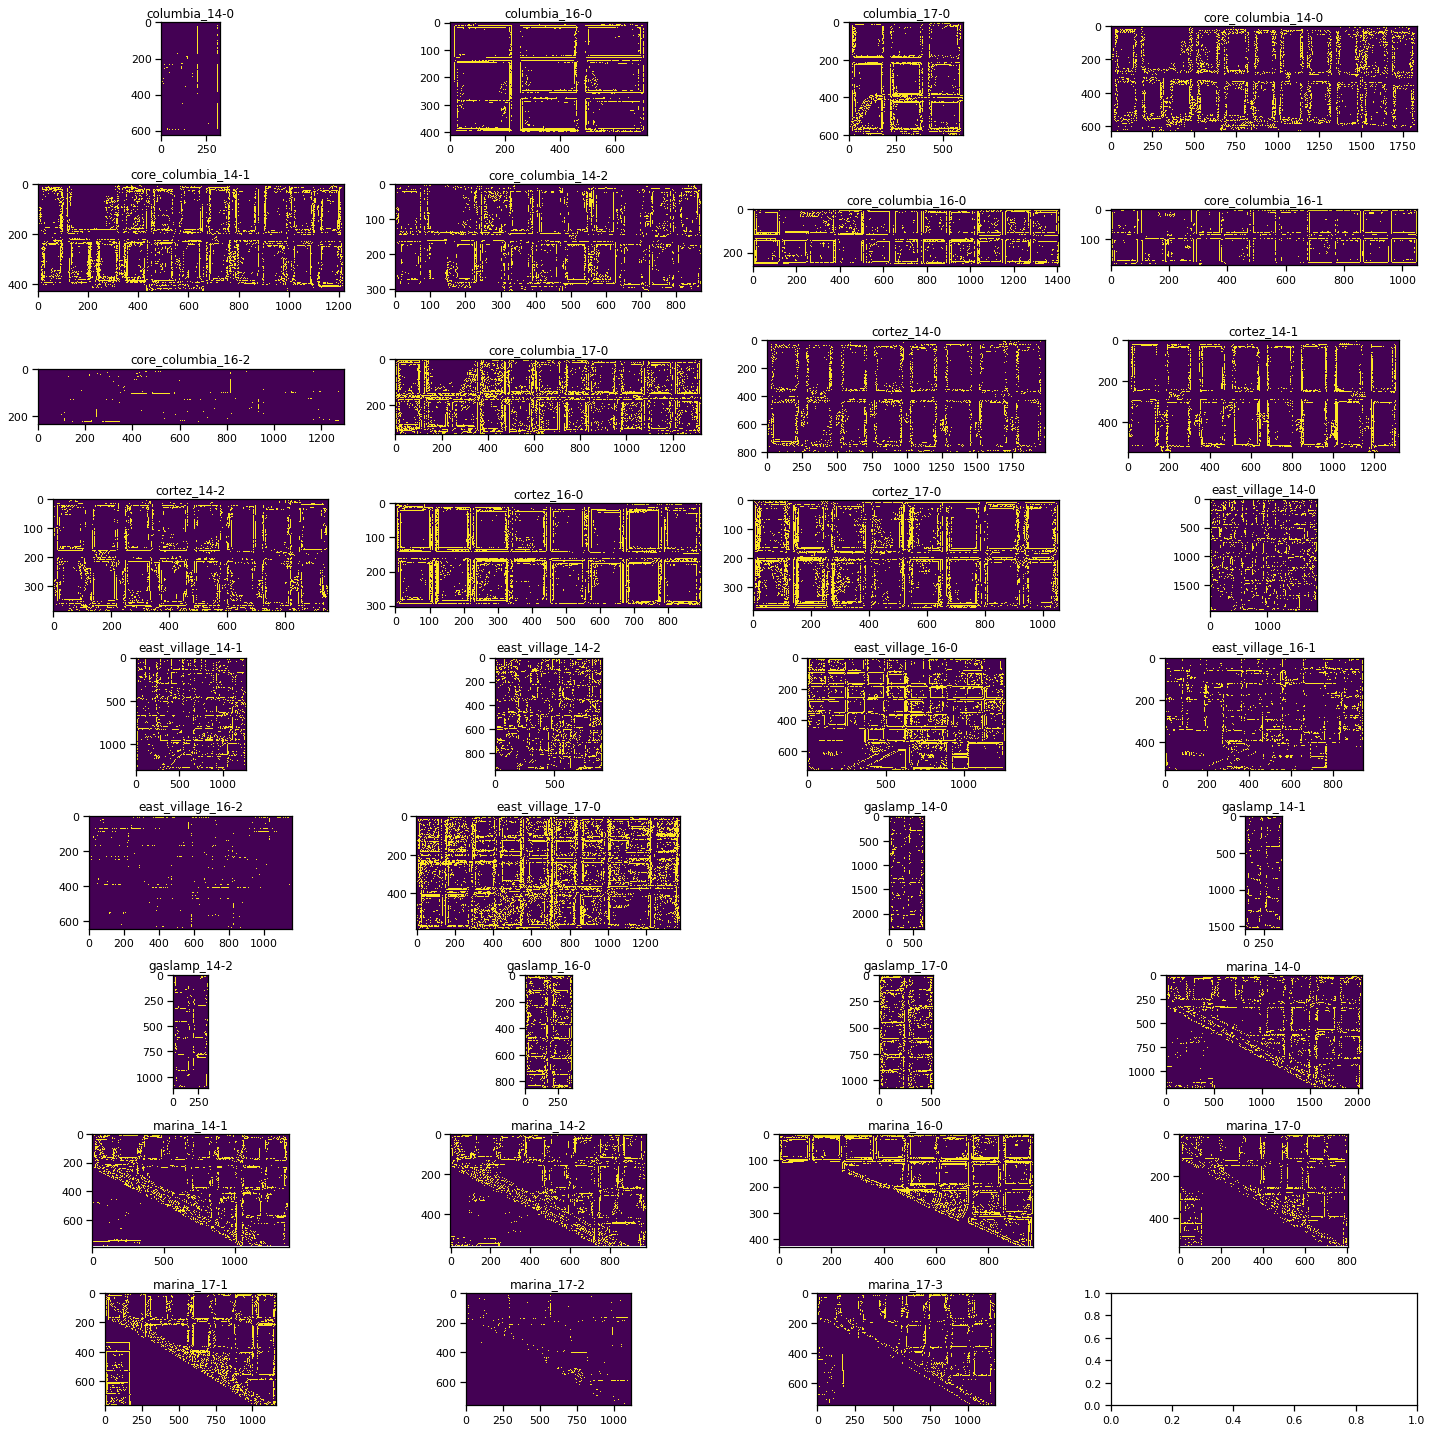

In [15]:
import cv2

def thresh(img):
    try:
        t = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        # Guess that the problem is it already greyscale
        t = img
    
    t = cv2.bitwise_not(t)
    return cv2.adaptiveThreshold(t, 1,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,0)


def crop_to_poly(r):
    
    img = get_image(r.image_url)

    (minx, miny, maxx, maxy) = [ int(e) for e in wkt.loads(r.source).bounds]

    return img[miny:maxy, minx:maxx]

def average_images(images):
  
    sum_img = None
    
    for img in images:
    
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.bitwise_not(gray)

        thresh = cv2.adaptiveThreshold(gray, 1,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,0)

        if sum_img is None:
            sum_img = thresh.copy()
            
        else:
            thresh = cv2.resize(thresh, (sum_img.shape[1], sum_img.shape[0]) )
            try:
                sum_img = cv2.add(sum_img,thresh)
            except:
                print("ERROR", sum_img.shape, thresh.shape)
                raise
            
    return sum_img

match_templates = {}

for name, g in df.groupby('map_cluster'):
    match_templates[name] = average_images([crop_to_poly(e) for _, e in g.iterrows()])
    
ncols, nrows = grid_shape(len(match_templates))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,20))

for ax, (name, img) in zip(axes.flat, match_templates.items()):
   
    ax.imshow(thresh(img))
    ax.set_title(name)  
    
plt.tight_layout()

Upper left of patch = (262.0, 257.0). Max location = (262, 257) 


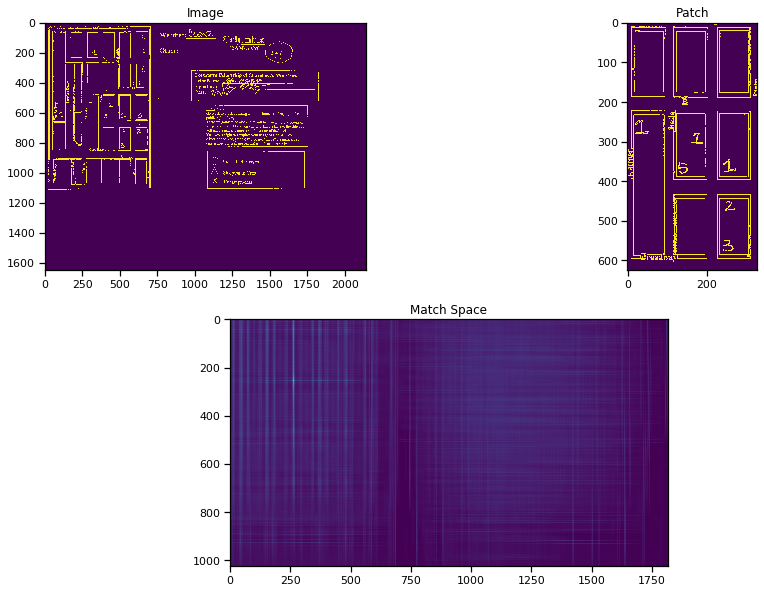

In [17]:

from dtcv.images import poly_to_array

def match_template(row, patch=None):
    
    img = thresh(get_image(row.image_url))
    
    if patch is None:
        patch = thresh(crop_to_poly(row))
        
    dst = cv2.matchTemplate(img, patch, cv2.TM_CCORR_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(dst)

    #ul = upper_left(row.source)
    ul = np.array(wkt.loads(row.source).bounds[:2]) # If the patch is skewed, ul of polt is not ul of patch
    
    distance =  np.linalg.norm(ul-max_loc)
    
    return distance, max_loc,  patch, dst

    
def plot_tm(row):
    
    img = thresh(get_image(row.image_url))

    patch = thresh(crop_to_poly(row))

    plt.figure(figsize=(16,10))

    ax = plt.subplot(221).imshow(img).axes
    ax.set_title("Image")

    ax = plt.subplot(222).imshow(patch).axes
    ax.set_title("Patch")

    distance, max_loc,  patch, dst = match_template(row, patch)

    ax = plt.subplot(212).imshow(dst).axes
    ax.set_title("Match Space");

    #ul = upper_left(wkt.loads(row.source))
    ul = wkt.loads(row.source).bounds[:2] # If the patch is skewed, ul of polt is not ul of patch
    
    print(f"Upper left of patch = {ul}. Max location = {max_loc} ")

plot_tm(df.iloc[0])

With a basic understanding of the template matching process, we can process all of the images, matching a template extracted form the same image. The max value from the template match should be in the same location as the upper-left of intersection region, since thats where the template is extract from. In this loop, we calculate the Eucledian distance between these two points, which should be zero. 

In [19]:
df['tm_dist'] = None

for name, row in df.iterrows():
    img = thresh(get_image(row.image_url))
    kernel = thresh(crop_to_poly(row))
    dst = cv2.matchTemplate(img, kernel, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(dst)

    #ul = upper_left(row.source)
    ul = np.array(wkt.loads(row.source).bounds[:2]) # If the patch is skewed, ul of polt is not ul of patch
    
    df.loc[name,'tm_dist'] = np.linalg.norm(ul-max_loc)
    

df['tm_dist'] = df.tm_dist.astype(float)

The ``tm_dist`` should be really small, hopefully zero, but there are a lot of records with a distance of .5 or .707. These are probably rounding errors. 

In [20]:
df.tm_dist.describe()

count    310.000000
mean       0.354554
std        0.293017
min        0.000000
25%        0.000000
50%        0.500000
75%        0.500000
max        0.707107
Name: tm_dist, dtype: float64

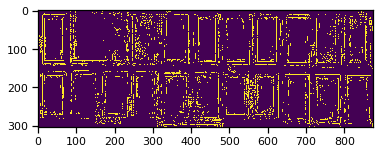

In [21]:


plt.imshow(thresh(list(match_templates.values())[5]))

In [22]:
df.head().T

,0,1,2,3,4
image_url,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....
neighborhood,columbia,columbia,columbia,columbia,columbia
year,2015,2016,2016,2016,2016
month,9,1,2,3,4
intersections_id,"Ketner_A,Ketner_Broadway,State_A,State_Broadway","Ketner_A,Ketner_Broadway,State_A,State_Broadway","Ketner_A,Ketner_Broadway,State_A,State_Broadway","Ketner_A,Ketner_Broadway,State_A,State_Broadway","Ketner_A,Ketner_Broadway,State_A,State_Broadway"
intersection_group,a,a,a,a,a
map_name,columbia_14,columbia_16,columbia_16,columbia_16,columbia_16
source_inv,"POLYGON ((262 1743, 262.5 1123, 585.5 1118.5, ...","POLYGON ((832.5 1161, 827.5 753.5, 1541.5 750....","POLYGON ((605 1426.5, 602 1086, 1188 1086, 118...","POLYGON ((844.5 1227.5, 848.5 777.5, 1626.5 77...","POLYGON ((627 1423, 626 1097.5, 1186.5 1095.5,..."
source,"POLYGON ((262 257, 262.5 877, 585.5 881.5, 590...","POLYGON ((832.5 839, 827.5 1246.5, 1541.5 1249...","POLYGON ((605 573.5, 602 914, 1188 914, 1185 5...","POLYGON ((844.5 772.5, 848.5 1222.5, 1626.5 12...","POLYGON ((627 577, 626 902.5, 1186.5 904.5, 11..."
source_area,202299,291446,197346,352782,182724


In [23]:
patches = list(match_templates.items())

def best_patches(row, patches):
    
    dists = []
    for name, patch in patches:
        try:
            distance, max_loc,  patch, dst = match_template(row, patch)
            dists.append((distance, name))
        except cv2.error as e:
            # Patch is larger than the image, which happens sometimes. 
            #print('Error', row.map_name, name, patch.shape, e)
            continue
        
    return list(sorted(dists))

In [24]:
for i,(idx, row) in enumerate(df.iterrows()):
    
    bp = best_patches(row, patches)
            
    print(idx, row.map_cluster, bp[0])
    
    if i > 10: 
        break
        
    

0 columbia_14-0 (0.0, 'columbia_14-0')
1 columbia_16-0 (0.5, 'columbia_16-0')
2 columbia_16-0 (38.51298482330343, 'marina_17-0')
3 columbia_16-0 (9.617692030835672, 'marina_17-0')
4 columbia_16-0 (55.94640292279746, 'columbia_16-0')
5 columbia_16-0 (37.31621631409058, 'cortez_17-0')
6 columbia_16-0 (20.554804791094465, 'core_columbia_14-2')
7 columbia_16-0 (18.66815470259447, 'core_columbia_14-2')
8 columbia_16-0 (5.315072906367325, 'marina_17-0')
9 columbia_16-0 (32.44225639501667, 'cortez_17-0')
10 columbia_16-0 (19.03943276465977, 'core_columbia_14-2')
11 columbia_16-0 (19.6596032513375, 'core_columbia_14-2')


In [33]:
all_patches =  [ (e.map_cluster, idx, get_image(e.image_url), crop_to_poly(e), thresh(crop_to_poly(e))) for idx, e in df.iterrows()]


In [34]:
import pickle as pkl
patches = [ (patch_idx, patch) for mc, patch_idx, img, crop, patch in all_patches]

with open('patches.pickle', 'wb') as f:
    pkl.dump(patches, f)


In [36]:
%%time
from tqdm import tqdm_notebook
from joblib import Parallel, delayed
from itertools import chain


def match(idx, row):
    import pickle as pkl
    matches = []
   
    try:
        with open('patches.pickle', 'rb') as f:
            patches = pkl.load(f)

        for dist, patch_idx in best_patches(row, patches):
            matches.append((idx, patch_idx, dist))
    except Exception as e:
        return []
    
    return matches

#matches = Parallel(n_jobs=12)(delayed(match)(idx, row) for idx, row in df.iloc[0:1].iterrows())

CPU times: user 3.43 ms, sys: 3.62 ms, total: 7.05 ms
Wall time: 7.28 ms


In [37]:
%%time 

def match(idx, row, patches):
    import pickle as pkl
    matches = []
   
    try:
        for dist, patch_idx in best_patches(row, patches):
            matches.append((idx, patch_idx, dist))
    except Exception as e:
        return []
    
    return matches

#matches = Parallel(n_jobs=12, prefer='threads')(delayed(match)(idx, row, patches) for idx, row in df.iterrows())



CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 11 µs
